# Standarize Rasters
## Responsabilities of this file
* Crop and standarize rasters on brazilian territory
* Create masks of brazilian territory
* Calculating mean and std from rasters on brazilian territory
* Plotting scaled and unscaled histograms on brazilian territory


## Who is Running?

In [ ]:
project_root = "/content/drive/MyDrive/TFC_MatheusSasso"
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Fixed Parameters

In [ ]:
# Reference Data Paths
ref_image_path = "/content/drive/My Drive/TFC_MatheusSasso/Data/Rasters/Envirem_Rasters/envir11_PET_coldest_quarter.tif"
shapefiles_folder = project_root + "/Data/Shapefiles/Shapefiles_Brasil"
rasters_root_folders_list =  [project_root+"/Data/Rasters/Elevation_Rasters", project_root+"/Data/Rasters/Bioclim_Rasters",project_root+"/Data/Rasters/Envirem_Rasters"]

# Output Paths
base_txt_files_path = project_root + "/Data/Standarized_Brazil_Data/TXT_Aux_Files"
base_csv_files_path = project_root + "/Data/Standarized_Brazil_Data/CSV_Aux_Files"
base_numpy_files_path = project_root + "/Data/Standarized_Brazil_Data/Numpy_Aux_Files" 
base_rasters_path = project_root + "/Data/Standarized_Brazil_Data/Base_Rasters" 
histograms_output_path = project_root+ "/Data/Input_Variables_Histograms"
standarized_rasters_root= project_root+"/Data/Standarized_Brazil_Data"
standarized_rasters_root_folders_list = [standarized_rasters_root+"/Elevation_Rasters",standarized_rasters_root+"/Bioclim_Rasters",standarized_rasters_root+"/Envirem_Rasters"]

# Output File Names
territory_mask_name = "brazilian_mask_standarized.tif"
territory_mask_path = os.path.join(base_rasters_path,territory_mask_name)

# Brazil Limits
country_limits = (-73.981934,-34.792929, -33.750035, 5.271478) 


## Package Downloads

In [ ]:
! pip install geopandas --quiet
! pip install rasterio --quiet

## Import

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from natsort import natsorted
import subprocess
import shutil
from osgeo import ogr, gdal
import rasterio
from rasterio import Affine
from rasterio.plot import show

##  Retrieving aux Classes

In [ ]:
!wget https://raw.githubusercontent.com/climate-and-health-datasci-Unicamp/permapy/main/utils/raster_utils.py
!wget https://raw.githubusercontent.com/climate-and-health-datasci-Unicamp/permapy/main/utils/utils.py

--2020-12-23 13:05:11--  https://raw.githubusercontent.com/climate-and-health-datasci-Unicamp/permapy/main/utils/raster_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4622 (4.5K) [text/plain]
Saving to: ‘raster_utils.py.1’

raster_utils.py.1   100%[===================>]   4.51K  --.-KB/s    in 0s      

2020-12-23 13:05:11 (55.3 MB/s) - ‘raster_utils.py.1’ saved [4622/4622]

--2020-12-23 13:05:11--  https://raw.githubusercontent.com/climate-and-health-datasci-Unicamp/permapy/main/utils/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200

In [ ]:
from utils import Utils
from raster_utils import Raster_Utils

raster_utils = Raster_Utils()
utils_methods = Utils()

## Shapefiles

In [ ]:
shapefile_brasi_pais_folder = shapefiles_folder + '/Pais'
brasil_pais_shp = os.path.join(shapefile_brasi_pais_folder, 'BRA_adm0.shp')

## Create if necessary Standarized Data Folders

In [ ]:
utils_methods.create_folder_structure(base_txt_files_path)
utils_methods.create_folder_structure(base_csv_files_path)
utils_methods.create_folder_structure(base_rasters_path)
utils_methods.create_folder_structure(base_numpy_files_path)
utils_methods.create_folder_structure(histograms_output_path)

## Useful Functions

Function to crop raster and standarize it on brazilian region

In [ ]:
def standarize_raster_to_brazil_region(image_path:str,base_output_root:str,country_limits,utils_methods):
  img_name = image_path.split("/")[-1]
  print(f"Standarizing image: {img_name}...")

  def get_window_from_extent(aff,country_limits):
    """ Get a portion form a raster array based on the country limits"""
    col_start, row_start = ~aff * (country_limits[0],country_limits[3])
    col_stop, row_stop = ~aff * (country_limits[1],country_limits[2])
    return ((int(row_start), int(row_stop)), (int(col_start), int(col_stop)))


  #Country Limits
  security_limt = 1
  x_min_limit = country_limits[0] -security_limt # DMS Coords: 07°32′39″S 073°59′04″W; Decimal Coords Geohack: -7.544167, -73.984444; Corrdenada Decimal epsg.io: -7.535403, -73.981934
  x_max_limit = country_limits[1] +security_limt # DMS Coords: 07°09′28″S 034°47′38″W; Decimal Coords Geohack: -20.474444, -28.840556; Corrdenada Decimal epsg.io: -7.155017, -34.792929
  y_min_limit = country_limits[2] -security_limt # DMS Coords: 33°45′09″S 053°22′07″W; Decimal Coords Geohack: -33.7525, -53.368611; Corrdenada Decimal epsg.io: -33.750035, -53.407288
  y_max_limit = country_limits[3] +security_limt # DMS Coords: 05°15′05″N 060°12′33″W; Decimal Coords Geohack: 5.251389, -60.209167; Corrdenada Decimal epsg.io: 5.271478, -60.214691  
  country_limits_secure = (x_min_limit,x_max_limit,y_min_limit,y_max_limit)

  #Getting Src Image Infos
  src=rasterio.open(image_path)

  window_region = get_window_from_extent(src.meta['transform'],country_limits_secure)
  band=src.read(1,window =window_region)
  data = band.copy()
  profile = src.profile
  
  #Default Affine Options
  resolution = profile['transform'][0]
  rot1 = profile['transform'][1]
  x_init_point = profile['transform'][2]
  rot2 = profile['transform'][3]
  n_resolution = profile['transform'][4]
  y_init_point = profile['transform'][5]

  #Creating Grids
  xgrid = np.arange(x_min_limit, x_max_limit, resolution)
  ygrid = np.arange(y_min_limit, y_max_limit, resolution)
  Nx = len(xgrid)
  Ny = len(ygrid)

  #1 - Converting data to np.float32
  if profile['dtype'] != np.float32:
      # data = data.astype(rasterio.float32)
      data = np.float32(data)
      profile['dtype'] = np.float32
  
  #2 - Converting no data to -9999.0
  # Note that form brazilian mask. The background is 0. So it wont be affected
  if profile['nodata'] != -9999.0:
      data = np.where(data < -9999.0 ,-9999.0, data)
      profile['nodata'] =  -9999.0

  #3 - Changing width and height to the cropped region  
  profile['width'] = data.shape[1]
  profile['height'] = data.shape[0]

  #4 - setting CRS
  profile['crs'] = {'init': 'EPSG:4326'}

  #5 - Changing Affine parameters
  # Example: Affine(0.008333333333333333, 0.0, -180.0, 0.0, -0.008333333333333333, 90.0)
  profile["transform"] =  Affine(resolution,rot1,x_min_limit,rot2,n_resolution,y_max_limit)

  #6 - Saving Destination Pathj
  objective_root_name = "/" + base_output_root.split("/")[-1] + "/"
  default_root_name = "/" + image_path.split("/")[-3] + "/"
  dst_path = image_path.replace(default_root_name,objective_root_name)
  dst_root_folder = "/".join(dst_path.split("/")[:-1])
  utils_methods.create_folder_structure(dst_root_folder)

  print(f"Destination Profile:\n{profile}")
  print(f"Destination Array:\n{data}")
  print("----------------------------------")
  with rasterio.open(dst_path, 'w', **profile) as dst:
      dst.write(data, 1)
      

Function to Burn mask on the map

In [ ]:
# A script to rasterise a shapefile to the same projection & pixel resolution as a reference image.
def create_base_raster(burnVal:int,ref_image_path:str,output_image_name:str,shapefile_vector_path=None):
    InputVector = shapefile_vector_path

    gdalformat = 'GTiff'
    datatype = gdal.GDT_Byte
    ##########################################################
    # Get projection info from reference image
    Image = gdal.Open(ref_image_path, gdal.GA_ReadOnly)

    # Open Shapefile
    Shapefile = ogr.Open(InputVector)
    Shapefile_layer = Shapefile.GetLayer()

    # Rasterise
    print("Rasterising shapefile...")
    Output = gdal.GetDriverByName(gdalformat).Create(output_image_name, Image.RasterXSize, Image.RasterYSize, 1, datatype, options=['COMPRESS=DEFLATE'])
    Output.SetProjection(Image.GetProjectionRef())
    Output.SetGeoTransform(Image.GetGeoTransform()) 

    # Write data to band 1
    Band = Output.GetRasterBand(1)
    Band.SetNoDataValue(0)
    gdal.RasterizeLayer(Output, [1], Shapefile_layer, burn_values=[burnVal])

    # Close datasets
    Band = None
    Output = None
    Image = None
    Shapefile = None

    # Build image overviews
    subprocess.call("gdaladdo --config COMPRESS_OVERVIEW DEFLATE "+output_image_name+" 2 4 8 16 32 64", shell=True)
    print("Done.")

Function to plot and save raster as a png image

In [ ]:
def plot_raster(raster,output_path,title,x_label,y_label,style):
    array= raster.read(1)
    print("Array: \n",array)
    plt.imshow(array, cmap=style)
    plt.title(title,fontsize=20)
    plt.ylabel(y_label,fontsize=18)
    plt.xlabel(x_label,fontsize=18)
    plt.savefig(f"{output_path}.png")
    plt.show()

Function to generate and sabe histograms

In [ ]:
def saving_input_vars_histograms(df,output_path:str,suptitle:str):
  df.hist(layout=(10,4),figsize=(20,20))
  plt.suptitle(suptitle,fontsize = 40)
  plt.tight_layout()
  plt.subplots_adjust(top=0.92)
  plt.savefig(output_path)
  plt.show()
  plt.clf()

## Creating Base Rasters

List of original rasters

In [ ]:
list_raster_files=[]
list_names_raster=[]

for raster_root_folder in rasters_root_folders_list:
  for root, dirs, files in os.walk(raster_root_folder):
      for file in files:
          if file.endswith('.tif') and "mask" not in file:
              list_raster_files.append(raster_root_folder+"/"+file)
              name=file.replace(".tif","")
              list_names_raster.append(name)
print(list_raster_files)
print(list_names_raster)

['/content/drive/MyDrive/TFC_MatheusSasso/Data/Rasters/Elevation_Rasters/elev1_strm_worldclim_elevation.tif', '/content/drive/MyDrive/TFC_MatheusSasso/Data/Rasters/Elevation_Rasters/elev3_envirem_topographic_wetness_index.tif', '/content/drive/MyDrive/TFC_MatheusSasso/Data/Rasters/Elevation_Rasters/elev2_envirem_terrain_roughness_index.tif', '/content/drive/MyDrive/TFC_MatheusSasso/Data/Rasters/Bioclim_Rasters/bio5_max_temperature_of_warmest_month.tif', '/content/drive/MyDrive/TFC_MatheusSasso/Data/Rasters/Bioclim_Rasters/bio1_annual_mean_temperature.tif', '/content/drive/MyDrive/TFC_MatheusSasso/Data/Rasters/Bioclim_Rasters/bio2_mean_diurnal_range.tif', '/content/drive/MyDrive/TFC_MatheusSasso/Data/Rasters/Bioclim_Rasters/bio3_isothermality.tif', '/content/drive/MyDrive/TFC_MatheusSasso/Data/Rasters/Bioclim_Rasters/bio4_temperature_seasonality.tif', '/content/drive/MyDrive/TFC_MatheusSasso/Data/Rasters/Bioclim_Rasters/bio6_min_temperature_of_coldest_month.tif', '/content/drive/MyDrive

Reading only Brailian Teritoy Region Raster


In [ ]:
for raster_file in list_raster_files:
  standarize_raster_to_brazil_region(raster_file,standarized_rasters_root,country_limits,utils_methods)

Standarizing image: elev1_strm_worldclim_elevation.tif...
Destination Profile:
{'driver': 'GTiff', 'dtype': <class 'numpy.float32'>, 'nodata': -9999.0, 'width': 4942, 'height': 4923, 'count': 1, 'crs': {'init': 'EPSG:4326'}, 'transform': Affine(0.008333333333333333, 0.0, -74.981934,
       0.0, -0.008333333333333333, 6.271478), 'tiled': False, 'compress': 'deflate', 'interleave': 'band'}
Destination Array:
[[ 1447.  1380.  1308. ... -9999. -9999. -9999.]
 [ 1389.  1293.  1127. ... -9999. -9999. -9999.]
 [ 1228.  1185.  1122. ... -9999. -9999. -9999.]
 ...
 [-9999. -9999. -9999. ... -9999. -9999. -9999.]
 [-9999. -9999. -9999. ... -9999. -9999. -9999.]
 [-9999. -9999. -9999. ... -9999. -9999. -9999.]]
----------------------------------
Standarizing image: elev3_envirem_topographic_wetness_index.tif...
Destination Profile:
{'driver': 'GTiff', 'dtype': <class 'numpy.float32'>, 'nodata': -9999.0, 'width': 4942, 'height': 4923, 'count': 1, 'crs': {'init': 'EPSG:4326'}, 'transform': Affine(0

## Listing files for future oredered reading

Saving TXTs

In [ ]:
list_raster_files=[]
list_names_raster=[]

# Fill lists
for raster_root_folder in standarized_rasters_root_folders_list:
  for root, dirs, files in os.walk(raster_root_folder):
      for file in files:
          if file.endswith('.tif') and "stacked" not in file:
              list_raster_files.append(raster_root_folder+"/"+file)
              name=file.replace(".tif","")
              list_names_raster.append(name)

# Smart string sorting
list_raster_files=natsorted(list_raster_files,key=lambda y: y.lower())
list_names_raster=natsorted(list_names_raster,key=lambda y: y.lower())

print(list_raster_files)
print(list_names_raster)

# Saving to .txt
myfile = open(base_txt_files_path+'/list_raster_files.txt', 'w+')
for item in list_raster_files:
    myfile.write(item+"\n")
myfile.close()


myfile = open(base_txt_files_path+'/list_names_raster.txt', 'w+')
for item in list_names_raster:
    myfile.write(item+"\n")
myfile.close()

['/content/drive/MyDrive/TFC_MatheusSasso/Data/Standarized_Brazil_Data/Bioclim_Rasters/bio1_annual_mean_temperature.tif', '/content/drive/MyDrive/TFC_MatheusSasso/Data/Standarized_Brazil_Data/Bioclim_Rasters/bio2_mean_diurnal_range.tif', '/content/drive/MyDrive/TFC_MatheusSasso/Data/Standarized_Brazil_Data/Bioclim_Rasters/bio3_isothermality.tif', '/content/drive/MyDrive/TFC_MatheusSasso/Data/Standarized_Brazil_Data/Bioclim_Rasters/bio4_temperature_seasonality.tif', '/content/drive/MyDrive/TFC_MatheusSasso/Data/Standarized_Brazil_Data/Bioclim_Rasters/bio5_max_temperature_of_warmest_month.tif', '/content/drive/MyDrive/TFC_MatheusSasso/Data/Standarized_Brazil_Data/Bioclim_Rasters/bio6_min_temperature_of_coldest_month.tif', '/content/drive/MyDrive/TFC_MatheusSasso/Data/Standarized_Brazil_Data/Bioclim_Rasters/bio7_temperature_annual_range.tif', '/content/drive/MyDrive/TFC_MatheusSasso/Data/Standarized_Brazil_Data/Bioclim_Rasters/bio8_mean_temperature_of_wettest_quarter.tif', '/content/drive

## Create Brazilian Mask

In [ ]:
create_base_raster(burnVal=255,
                   ref_image_path = ref_image_path,
                   output_image_name = territory_mask_name,
                   shapefile_vector_path=brasil_pais_shp)

shutil.copy("/content/"+territory_mask_name, territory_mask_path)
standarize_raster_to_brazil_region(territory_mask_path,standarized_rasters_root,country_limits,utils_methods)

Rasterising shapefile...
Done.
Standarizing image: brazilian_mask_standarized.tif...
Destination Profile:
{'driver': 'GTiff', 'dtype': <class 'numpy.float32'>, 'nodata': -9999.0, 'width': 4942, 'height': 4923, 'count': 1, 'crs': {'init': 'EPSG:4326'}, 'transform': Affine(0.00833333333333334, 0.0, -74.981934,
       0.0, -0.008333333333333333, 6.271478), 'tiled': False, 'compress': 'deflate', 'interleave': 'band'}
Destination Array:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
----------------------------------


Showing Raster

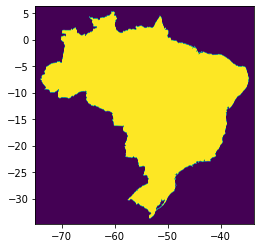

{'count': 1,
 'crs': CRS.from_epsg(4326),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 4923,
 'nodata': -9999.0,
 'transform': Affine(0.00833333333333334, 0.0, -74.981934,
       0.0, -0.008333333333333333, 6.271478),
 'width': 4942}

In [ ]:
brazilian_mask_raster = rasterio.open(territory_mask_path)
show((brazilian_mask_raster, 1))
brazilian_mask_raster.meta

Array: 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


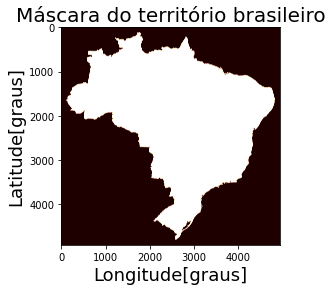

In [ ]:
plot_raster(raster = brazilian_mask_raster,
            output_path = os.path.join(base_rasters_path,"plot_for_report_brazilian_mask.png"),
            title='Máscara do território brasileiro',
            x_label='Longitude[graus]',
            y_label='Latitude[graus]',
            style = 'pink'
            )

## Creating a Dataframe With All Coordinates In Brazil

In [ ]:
brazilian_mask_raster = rasterio.open(os.path.join(base_rasters_path,territory_mask_name))

In [ ]:
brazil_coords_df = pd.DataFrame(columns = ['row','col','latitude','longitude'])
brazilian_mask_raster_array = brazilian_mask_raster.read(1)
brazilian_mask_raster_meta = brazilian_mask_raster.meta
height = brazilian_mask_raster_meta['height']
width = brazilian_mask_raster_meta['width']
transform = brazilian_mask_raster_meta['transform']
dict_brazil = {}
i = 0
for w in range(width):
  for h in range(height):
    val = brazilian_mask_raster_array[h,w] # Os rasters são disponibilizados (Height,Width)
    if val != 0.0: #255 for territoy and 0 for ocean
      long = transform[2] + transform[0]*w
      lati = transform[5] + transform[4]*h
      dict_brazil[i] = {'row':h, 'col':w, 'latitude':lati, 'longitude':long}
      i = i + 1
      
brazil_coords_df = pd.DataFrame.from_dict(dict_brazil, "index") 
brazil_coords_df.head()

In [ ]:
utils_methods.create_folder_structure(base_csv_files_path)
brazil_coords_df.to_csv(f"{base_csv_files_path}/brazil_coords.csv",index = False, header=True)

## Extracting Enverionment Data for All Coordinates In Brazil 

Beacuse extracts those data takes to long. If coolab loose conections (what happened in my case) there is a code to merge df parts and save the final data

In [ ]:
brazil_coords_df = pd.read_csv(f"{base_csv_files_path}/brazil_coords.csv")
list_raster_files = open(f"{base_txt_files_path}/list_raster_files.txt", 'r').read().splitlines()
list_names_raster = open(f"{base_txt_files_path}/list_names_raster.txt", 'r').read().splitlines()

You should run multiple times to have the complete aray. The colab memory will break, so use start until you have the complete .csv

In [ ]:
start = 0

In [ ]:
#Maybe it is necessary to run by list_raster_files,list_names_raster slices
try:
  brazil_env_info_coords_df = pd.read_csv(f"{base_csv_files_path}/brazil_coords_env_info.csv")
except:
  brazil_env_info_coords_df = brazil_coords_df.copy()



for i,(fp,nr) in enumerate(zip(list_raster_files[start:],list_names_raster[start:])):
    raster = rasterio.open(fp)
    raster_array = raster.read(1)
    dict_env_info_brazil_column = {}
    dict_env_info_brazil_column = {index:{nr:raster_array[int(row['row']),int(row['col'])]} for index,row in brazil_coords_df.iterrows()}
    df_env_info_column = pd.DataFrame.from_dict(dict_env_info_brazil_column, "index")
    brazil_env_info_coords_df = brazil_env_info_coords_df.merge(df_env_info_column, left_index=True, right_index=True)

    brazil_env_info_coords_df.to_csv(f"{base_csv_files_path}/brazil_coords_env_info.csv",index = False, header=True)

In [ ]:
brazil_env_info_coords_df = pd.read_csv(f"{base_csv_files_path}/brazil_coords_env_info.csv")
brazil_env_info_coords_df.head()

,row,col,latitude,longitude,bio1_annual_mean_temperature,bio2_mean_diurnal_range,bio3_isothermality,bio4_temperature_seasonality,bio5_max_temperature_of_warmest_month,bio6_min_temperature_of_coldest_month,bio7_temperature_annual_range,bio8_mean_temperature_of_wettest_quarter,bio9_mean_temperature_of_driest_quarter,bio10_mean_temperature_of_warmest_quarter,bio11_mean_temperature_of_coldest_quarter,bio12_annual_precipitation,bio13_precipitation_of_wettest_month,bio14_precipitation_of_driest_month,bio15_precipitation_seasonality,bio16_precipitation_of_wettest_quarter,bio17_precipitation_of_driest_quarter,bio18_precipitation_of_warmest_quarter,bio19_precipitation_of_coldest_quarter,elev1_strm_worldclim_elevation,elev2_envirem_terrain_roughness_index,elev3_envirem_topographic_wetness_index,envir1_annual_PET,envir2_aridity_index_thornthwaite,envir3_climatic_moisture_index,envir4_continentality,envir5_embergers_pluviothermic_quotient,envir6_growing_deg_days_0,envir7_growing_deg_days_5,envir8_max_temp_coldest,envir9_min_temp_warmest,envir10_month_count_by_temp_10,envir11_PET_coldest_quarter,envir12_PET_driest_quarter,envir13_PET_seasonality,envir14_PET_warmest_quarter,envir15_PET_wettest_quarter,envir16_thermicity_index
0,1657,119,-7.536855,-73.990267,25.512501,10.308333,81.167976,46.569839,31.6,18.9,12.700001,25.566666,24.866667,25.983334,24.866667,2139.0,277.0,73.0,36.991142,738.0,261.0,632.0,261.0,306.0,6.88,12.85,1747.290039,27.160000,0.21,1.75,525.299988,111114.0,111114.0,308.0,207.0,12.0,126.040001,133.929993,1393.589966,157.619995,143.830002,676.5
1,1658,119,-7.545189,-73.990267,25.495832,10.325000,81.299202,47.071430,31.6,18.9,12.700001,25.549999,24.833334,25.966667,24.833334,2135.0,278.0,72.0,37.145275,738.0,259.0,630.0,259.0,313.0,6.25,13.01,1747.250000,27.330000,0.21,1.75,524.349976,111114.0,111114.0,308.0,207.0,12.0,126.019997,133.919998,1391.430054,157.619995,144.020004,676.5
2,1659,119,-7.553522,-73.990267,25.508333,10.300000,81.102356,46.163410,31.6,18.9,12.700001,25.566666,24.866667,25.966667,24.866667,2134.0,278.0,71.0,37.103928,737.0,260.0,630.0,260.0,308.0,8.62,12.49,1746.979980,27.440001,0.21,1.75,523.159973,111078.0,111078.0,308.0,207.0,12.0,126.010002,133.899994,1388.270020,159.389999,144.020004,676.5
3,1657,120,-7.536855,-73.981934,25.504166,10.325000,81.299210,47.503986,31.6,18.9,12.700001,25.566666,24.833334,25.983334,24.833334,2143.0,278.0,72.0,37.300240,740.0,259.0,635.0,259.0,309.0,2.75,12.97,1746.979980,27.070000,0.21,1.85,526.960022,111132.0,111132.0,307.0,207.0,12.0,125.809998,133.699997,1416.560059,158.029999,143.539993,676.5
4,1658,120,-7.545189,-73.981934,25.491667,10.333333,81.364822,46.992905,31.6,18.9,12.700001,25.533333,24.833334,25.966667,24.833334,2142.0,279.0,71.0,37.238876,740.0,260.0,634.0,260.0,314.0,5.38,13.04,1747.010010,27.090000,0.21,1.75,525.530029,111078.0,111078.0,308.0,207.0,12.0,126.019997,133.919998,1387.479980,159.389999,144.020004,676.5


## Saving Mean Std values for Each Raster (Exluding possible no data values[-9999.0]) and creating stacked enverionment data numpoy array

Retrieving list of raster file paths and raster names

In [ ]:
list_raster_files = open(f"{base_txt_files_path}/list_raster_files.txt", 'r').read().splitlines()
list_names_raster = open(f"{base_txt_files_path}/list_names_raster.txt", 'r').read().splitlines()

Stacking and saving stack as a base numpy array

In [ ]:
raster_coverages_list = []
for rasters_path in list_raster_files:
    raster_coverages,_,_,_,_,_ = raster_utils.get_raster_infos(rasters_path)
    raster_coverages_list.append(raster_coverages)
    raster_coverages = None

stacked_raster_coverages = np.concatenate([[x for x in raster_coverages_list]], axis=0)
del raster_coverages_list
print("Stack finished")

utils_methods.save_nparray_to_folder(np_array=stacked_raster_coverages,
                       folder_path=base_numpy_files_path,
                       filename="stacked_environment_rasters_array")


Reading raster bio1_annual_mean_temperature.tif
Reading raster bio2_mean_diurnal_range.tif
Reading raster bio3_isothermality.tif
Reading raster bio4_temperature_seasonality.tif
Reading raster bio5_max_temperature_of_warmest_month.tif
Reading raster bio6_min_temperature_of_coldest_month.tif
Reading raster bio7_temperature_annual_range.tif
Reading raster bio8_mean_temperature_of_wettest_quarter.tif
Reading raster bio9_mean_temperature_of_driest_quarter.tif
Reading raster bio10_mean_temperature_of_warmest_quarter.tif
Reading raster bio11_mean_temperature_of_coldest_quarter.tif
Reading raster bio12_annual_precipitation.tif
Reading raster bio13_precipitation_of_wettest_month.tif
Reading raster bio14_precipitation_of_driest_month.tif
Reading raster bio15_precipitation_seasonality.tif
Reading raster bio16_precipitation_of_wettest_quarter.tif
Reading raster bio17_precipitation_of_driest_quarter.tif
Reading raster bio18_precipitation_of_warmest_quarter.tif
Reading raster bio19_precipitation_of_

Calculating and saving means and stds to csv

In [ ]:
# Reshamping numpy array
stacked_raster_coverages_reshaped = np.copy(stacked_raster_coverages)#(38,4923, 4942)
stacked_raster_coverages_reshaped = np.transpose(stacked_raster_coverages_reshaped,(1,2,0)) #(4923, 4942,38)
stacked_raster_coverages_reshaped = np.reshape(stacked_raster_coverages_reshaped,(-1,stacked_raster_coverages_reshaped.shape[2]))#(24329466,38)
del stacked_raster_coverages

# Calculating means and stds
global_mean = np.zeros(shape=(0))
for i in range(stacked_raster_coverages_reshaped.shape[1]):
  mean = np.mean(stacked_raster_coverages_reshaped[:,i][stacked_raster_coverages_reshaped[:,i]>-9999.0])
  global_mean = np.append(global_mean, mean)
global_mean = np.float32(global_mean)

global_std = np.zeros(shape=(0))
for i in range(stacked_raster_coverages_reshaped.shape[1]):
  std = np.std(stacked_raster_coverages_reshaped[:,i][stacked_raster_coverages_reshaped[:,i]>-9999.0])
  global_std = np.append(global_std, std)
global_std = np.float32(global_std)

del stacked_raster_coverages_reshaped

# Creating Daataframe
dict_brazil_mean_std = {}
df_brazil_mean_std = pd.DataFrame(columns = ['variable','mean','std'])
for i,env_column in enumerate(list_names_raster):
  dict_brazil_mean_std[i] = {'variable':env_column, 'mean':global_mean[i], 'std':global_std[i]}
df_brazil_mean_std = pd.DataFrame.from_dict(dict_brazil_mean_std, "index") 
df_brazil_mean_std

,variable,mean,std
0,bio1_annual_mean_temperature,22.584848,5.250444
1,bio2_mean_diurnal_range,11.321326,2.033783
2,bio3_isothermality,69.393211,11.290104
3,bio4_temperature_seasonality,173.031479,149.052536
4,bio5_max_temperature_of_warmest_month,30.824163,4.299799
5,bio6_min_temperature_of_coldest_month,13.792878,7.415602
6,bio7_temperature_annual_range,17.031240,5.145769
7,bio8_mean_temperature_of_wettest_quarter,23.525322,4.901763
8,bio9_mean_temperature_of_driest_quarter,21.167664,6.319427
9,bio10_mean_temperature_of_warmest_quarter,24.516466,4.505254


Saving DataFrame

In [ ]:
mean_std_path = f"{base_csv_files_path}/brazil_vars_mean_std.csv"
df_brazil_mean_std.to_csv(mean_std_path,index = False, header=True)

## Fintering no data values from enverionment data for all coordinates in Brazil, replacing no data values by the median

In [ ]:
brazil_env_info_coords_df = pd.read_csv(f"{base_csv_files_path}/brazil_coords_env_info.csv")
filtered_brazil_env_info_coords_df = brazil_env_info_coords_df.copy()
del brazil_env_info_coords_df

In [ ]:
#Visualing the data it appears to be the same, but there are some no data values
#on the envirem dataset, probably on the country bounds because of the 
#differences between the shapefile and the raster

for (column_name, column_data) in filtered_brazil_env_info_coords_df.iteritems():
  if column_name not in ['row','col','latitude','longitude']:
    column_median = filtered_brazil_env_info_coords_df[column_name][filtered_brazil_env_info_coords_df[column_name]>-9999.0].median()
    column_data = column_data.to_numpy() 
    filtered_column_data = np.where(column_data <= -9999.0 ,column_median, column_data)
    filtered_brazil_env_info_coords_df[column_name] = filtered_column_data

filtered_brazil_env_info_coords_path = f"{base_csv_files_path}/filtered_brazil_coords_env_info.csv"
filtered_brazil_env_info_coords_df.to_csv(filtered_brazil_env_info_coords_path,index = False, header=True)
filtered_brazil_env_info_coords_df.head()

,row,col,latitude,longitude,bio1_annual_mean_temperature,bio2_mean_diurnal_range,bio3_isothermality,bio4_temperature_seasonality,bio5_max_temperature_of_warmest_month,bio6_min_temperature_of_coldest_month,bio7_temperature_annual_range,bio8_mean_temperature_of_wettest_quarter,bio9_mean_temperature_of_driest_quarter,bio10_mean_temperature_of_warmest_quarter,bio11_mean_temperature_of_coldest_quarter,bio12_annual_precipitation,bio13_precipitation_of_wettest_month,bio14_precipitation_of_driest_month,bio15_precipitation_seasonality,bio16_precipitation_of_wettest_quarter,bio17_precipitation_of_driest_quarter,bio18_precipitation_of_warmest_quarter,bio19_precipitation_of_coldest_quarter,elev1_strm_worldclim_elevation,elev2_envirem_terrain_roughness_index,elev3_envirem_topographic_wetness_index,envir1_annual_PET,envir2_aridity_index_thornthwaite,envir3_climatic_moisture_index,envir4_continentality,envir5_embergers_pluviothermic_quotient,envir6_growing_deg_days_0,envir7_growing_deg_days_5,envir8_max_temp_coldest,envir9_min_temp_warmest,envir10_month_count_by_temp_10,envir11_PET_coldest_quarter,envir12_PET_driest_quarter,envir13_PET_seasonality,envir14_PET_warmest_quarter,envir15_PET_wettest_quarter,envir16_thermicity_index
0,1657,119,-7.536855,-73.990267,25.512501,10.308333,81.167976,46.569839,31.6,18.9,12.700001,25.566666,24.866667,25.983334,24.866667,2139.0,277.0,73.0,36.991142,738.0,261.0,632.0,261.0,306.0,6.88,12.85,1747.290039,27.160000,0.21,1.75,525.299988,111114.0,111114.0,308.0,207.0,12.0,126.040001,133.929993,1393.589966,157.619995,143.830002,676.5
1,1658,119,-7.545189,-73.990267,25.495832,10.325000,81.299202,47.071430,31.6,18.9,12.700001,25.549999,24.833334,25.966667,24.833334,2135.0,278.0,72.0,37.145275,738.0,259.0,630.0,259.0,313.0,6.25,13.01,1747.250000,27.330000,0.21,1.75,524.349976,111114.0,111114.0,308.0,207.0,12.0,126.019997,133.919998,1391.430054,157.619995,144.020004,676.5
2,1659,119,-7.553522,-73.990267,25.508333,10.300000,81.102356,46.163410,31.6,18.9,12.700001,25.566666,24.866667,25.966667,24.866667,2134.0,278.0,71.0,37.103928,737.0,260.0,630.0,260.0,308.0,8.62,12.49,1746.979980,27.440001,0.21,1.75,523.159973,111078.0,111078.0,308.0,207.0,12.0,126.010002,133.899994,1388.270020,159.389999,144.020004,676.5
3,1657,120,-7.536855,-73.981934,25.504166,10.325000,81.299210,47.503986,31.6,18.9,12.700001,25.566666,24.833334,25.983334,24.833334,2143.0,278.0,72.0,37.300240,740.0,259.0,635.0,259.0,309.0,2.75,12.97,1746.979980,27.070000,0.21,1.85,526.960022,111132.0,111132.0,307.0,207.0,12.0,125.809998,133.699997,1416.560059,158.029999,143.539993,676.5
4,1658,120,-7.545189,-73.981934,25.491667,10.333333,81.364822,46.992905,31.6,18.9,12.700001,25.533333,24.833334,25.966667,24.833334,2142.0,279.0,71.0,37.238876,740.0,260.0,634.0,260.0,314.0,5.38,13.04,1747.010010,27.090000,0.21,1.75,525.530029,111078.0,111078.0,308.0,207.0,12.0,126.019997,133.919998,1387.479980,159.389999,144.020004,676.5


In [ ]:
del filtered_brazil_env_info_coords_df

## Creating Scaled Enverionment Dataframe

In [ ]:
df_brazil_mean_std = pd.read_csv(f"{base_csv_files_path}/brazil_vars_mean_std.csv")
filtered_brazil_env_info_coords_df = pd.read_csv(f"{base_csv_files_path}/filtered_brazil_coords_env_info.csv")
scaled_filtered_brazil_env_info_coords_df = filtered_brazil_env_info_coords_df.copy()

In [ ]:
for (column_name, column_data) in filtered_brazil_env_info_coords_df.iteritems():
  if column_name not in ['row','col','latitude','longitude']:
    variable_info = df_brazil_mean_std.loc[df_brazil_mean_std['variable'] == column_name]
    variable_mean = variable_info['mean'].to_numpy()
    variable_std = variable_info['std'].to_numpy()
    column_data_scaled = (column_data.to_numpy() - variable_mean)/variable_std
    scaled_filtered_brazil_env_info_coords_df[column_name] = column_data_scaled
    
del filtered_brazil_env_info_coords_df
scaled_filtered_brazil_env_info_coords_path = f"{base_csv_files_path}/scaled_filtered_brazil_coords_env_info.csv"
scaled_filtered_brazil_env_info_coords_df.to_csv(scaled_filtered_brazil_env_info_coords_path,index = False, header=True)
scaled_filtered_brazil_env_info_coords_df.head()

,row,col,latitude,longitude,bio1_annual_mean_temperature,bio2_mean_diurnal_range,bio3_isothermality,bio4_temperature_seasonality,bio5_max_temperature_of_warmest_month,bio6_min_temperature_of_coldest_month,bio7_temperature_annual_range,bio8_mean_temperature_of_wettest_quarter,bio9_mean_temperature_of_driest_quarter,bio10_mean_temperature_of_warmest_quarter,bio11_mean_temperature_of_coldest_quarter,bio12_annual_precipitation,bio13_precipitation_of_wettest_month,bio14_precipitation_of_driest_month,bio15_precipitation_seasonality,bio16_precipitation_of_wettest_quarter,bio17_precipitation_of_driest_quarter,bio18_precipitation_of_warmest_quarter,bio19_precipitation_of_coldest_quarter,elev1_strm_worldclim_elevation,elev2_envirem_terrain_roughness_index,elev3_envirem_topographic_wetness_index,envir1_annual_PET,envir2_aridity_index_thornthwaite,envir3_climatic_moisture_index,envir4_continentality,envir5_embergers_pluviothermic_quotient,envir6_growing_deg_days_0,envir7_growing_deg_days_5,envir8_max_temp_coldest,envir9_min_temp_warmest,envir10_month_count_by_temp_10,envir11_PET_coldest_quarter,envir12_PET_driest_quarter,envir13_PET_seasonality,envir14_PET_warmest_quarter,envir15_PET_wettest_quarter,envir16_thermicity_index
0,1657,119,-7.536855,-73.990267,0.557601,-0.498083,1.042928,-0.848437,0.180436,0.688699,-0.841709,0.416451,0.585338,0.325590,0.690302,0.700851,0.306753,0.703105,-0.960030,0.219595,0.777324,1.339033,-0.215828,-0.278530,-0.389038,0.566255,0.643951,-0.939639,0.780598,-0.766348,0.589571,0.581052,0.564583,0.768949,0.376457,0.26874,0.634557,0.398772,-0.634609,-0.085361,-0.013055,0.600689
1,1658,119,-7.545189,-73.990267,0.554426,-0.489888,1.054551,-0.845071,0.180436,0.688699,-0.841709,0.413051,0.580064,0.321891,0.685217,0.695760,0.316006,0.681466,-0.954105,0.219595,0.763913,1.328629,-0.221356,-0.271037,-0.404840,0.658427,0.643754,-0.932323,0.780598,-0.766348,0.585924,0.581052,0.564583,0.768949,0.376457,0.26874,0.633861,0.398450,-0.636109,-0.085361,-0.005971,0.600689
2,1659,119,-7.553522,-73.990267,0.556807,-0.502180,1.037116,-0.851163,0.180436,0.688699,-0.841709,0.416451,0.585338,0.321891,0.690302,0.694487,0.316006,0.659827,-0.955694,0.216283,0.770619,1.328629,-0.218592,-0.276389,-0.345396,0.358867,0.642421,-0.927589,0.780598,-0.766348,0.581355,0.579482,0.563108,0.768949,0.376457,0.26874,0.633514,0.397807,-0.638305,0.004471,-0.005971,0.600689
3,1657,120,-7.536855,-73.981934,0.556013,-0.489888,1.054552,-0.842169,0.180436,0.688699,-0.841709,0.416451,0.580064,0.325590,0.685217,0.705943,0.316006,0.681466,-0.948148,0.226218,0.763913,1.354638,-0.221356,-0.275319,-0.492626,0.635384,0.642421,-0.943512,0.780598,-0.741464,0.595944,0.581838,0.565321,0.752768,0.376457,0.26874,0.626562,0.391376,-0.618650,-0.064553,-0.023867,0.600689
4,1658,120,-7.545189,-73.981934,0.553633,-0.485791,1.060363,-0.845598,0.180436,0.688699,-0.841709,0.409651,0.580064,0.321891,0.685217,0.704670,0.325259,0.659827,-0.950507,0.226218,0.770619,1.349436,-0.218592,-0.269967,-0.426661,0.675709,0.642569,-0.942651,0.780598,-0.766348,0.590454,0.579482,0.563108,0.768949,0.376457,0.26874,0.633861,0.398450,-0.638854,0.004471,-0.005971,0.600689


## Getting Statistics from The data


Non Scaled Histograms

In [ ]:
filtered_brazil_env_info_coords_df = pd.read_csv(f"{base_csv_files_path}/filtered_brazil_coords_env_info.csv")
selection_filtered_brazil_env_info_coords_df = filtered_brazil_env_info_coords_df[filtered_brazil_env_info_coords_df.columns.difference(['row','col','latitude','longitude'])]
del filtered_brazil_env_info_coords_df
selection_filtered_brazil_env_info_coords_df = selection_filtered_brazil_env_info_coords_df[natsorted(selection_filtered_brazil_env_info_coords_df.columns)]
selection_filtered_brazil_env_info_coords_df.head()

,bio1_annual_mean_temperature,bio2_mean_diurnal_range,bio3_isothermality,bio4_temperature_seasonality,bio5_max_temperature_of_warmest_month,bio6_min_temperature_of_coldest_month,bio7_temperature_annual_range,bio8_mean_temperature_of_wettest_quarter,bio9_mean_temperature_of_driest_quarter,bio10_mean_temperature_of_warmest_quarter,bio11_mean_temperature_of_coldest_quarter,bio12_annual_precipitation,bio13_precipitation_of_wettest_month,bio14_precipitation_of_driest_month,bio15_precipitation_seasonality,bio16_precipitation_of_wettest_quarter,bio17_precipitation_of_driest_quarter,bio18_precipitation_of_warmest_quarter,bio19_precipitation_of_coldest_quarter,elev1_strm_worldclim_elevation,elev2_envirem_terrain_roughness_index,elev3_envirem_topographic_wetness_index,envir1_annual_PET,envir2_aridity_index_thornthwaite,envir3_climatic_moisture_index,envir4_continentality,envir5_embergers_pluviothermic_quotient,envir6_growing_deg_days_0,envir7_growing_deg_days_5,envir8_max_temp_coldest,envir9_min_temp_warmest,envir10_month_count_by_temp_10,envir11_PET_coldest_quarter,envir12_PET_driest_quarter,envir13_PET_seasonality,envir14_PET_warmest_quarter,envir15_PET_wettest_quarter,envir16_thermicity_index
0,25.512501,10.308333,81.167976,46.569839,31.6,18.9,12.700001,25.566666,24.866667,25.983334,24.866667,2139.0,277.0,73.0,36.991142,738.0,261.0,632.0,261.0,306.0,6.88,12.85,1747.290039,27.160000,0.21,1.75,525.299988,111114.0,111114.0,308.0,207.0,12.0,126.040001,133.929993,1393.589966,157.619995,143.830002,676.5
1,25.495832,10.325000,81.299202,47.071430,31.6,18.9,12.700001,25.549999,24.833334,25.966667,24.833334,2135.0,278.0,72.0,37.145275,738.0,259.0,630.0,259.0,313.0,6.25,13.01,1747.250000,27.330000,0.21,1.75,524.349976,111114.0,111114.0,308.0,207.0,12.0,126.019997,133.919998,1391.430054,157.619995,144.020004,676.5
2,25.508333,10.300000,81.102356,46.163410,31.6,18.9,12.700001,25.566666,24.866667,25.966667,24.866667,2134.0,278.0,71.0,37.103928,737.0,260.0,630.0,260.0,308.0,8.62,12.49,1746.979980,27.440001,0.21,1.75,523.159973,111078.0,111078.0,308.0,207.0,12.0,126.010002,133.899994,1388.270020,159.389999,144.020004,676.5
3,25.504166,10.325000,81.299210,47.503986,31.6,18.9,12.700001,25.566666,24.833334,25.983334,24.833334,2143.0,278.0,72.0,37.300240,740.0,259.0,635.0,259.0,309.0,2.75,12.97,1746.979980,27.070000,0.21,1.85,526.960022,111132.0,111132.0,307.0,207.0,12.0,125.809998,133.699997,1416.560059,158.029999,143.539993,676.5
4,25.491667,10.333333,81.364822,46.992905,31.6,18.9,12.700001,25.533333,24.833334,25.966667,24.833334,2142.0,279.0,71.0,37.238876,740.0,260.0,634.0,260.0,314.0,5.38,13.04,1747.010010,27.090000,0.21,1.75,525.530029,111078.0,111078.0,308.0,207.0,12.0,126.019997,133.919998,1387.479980,159.389999,144.020004,676.5


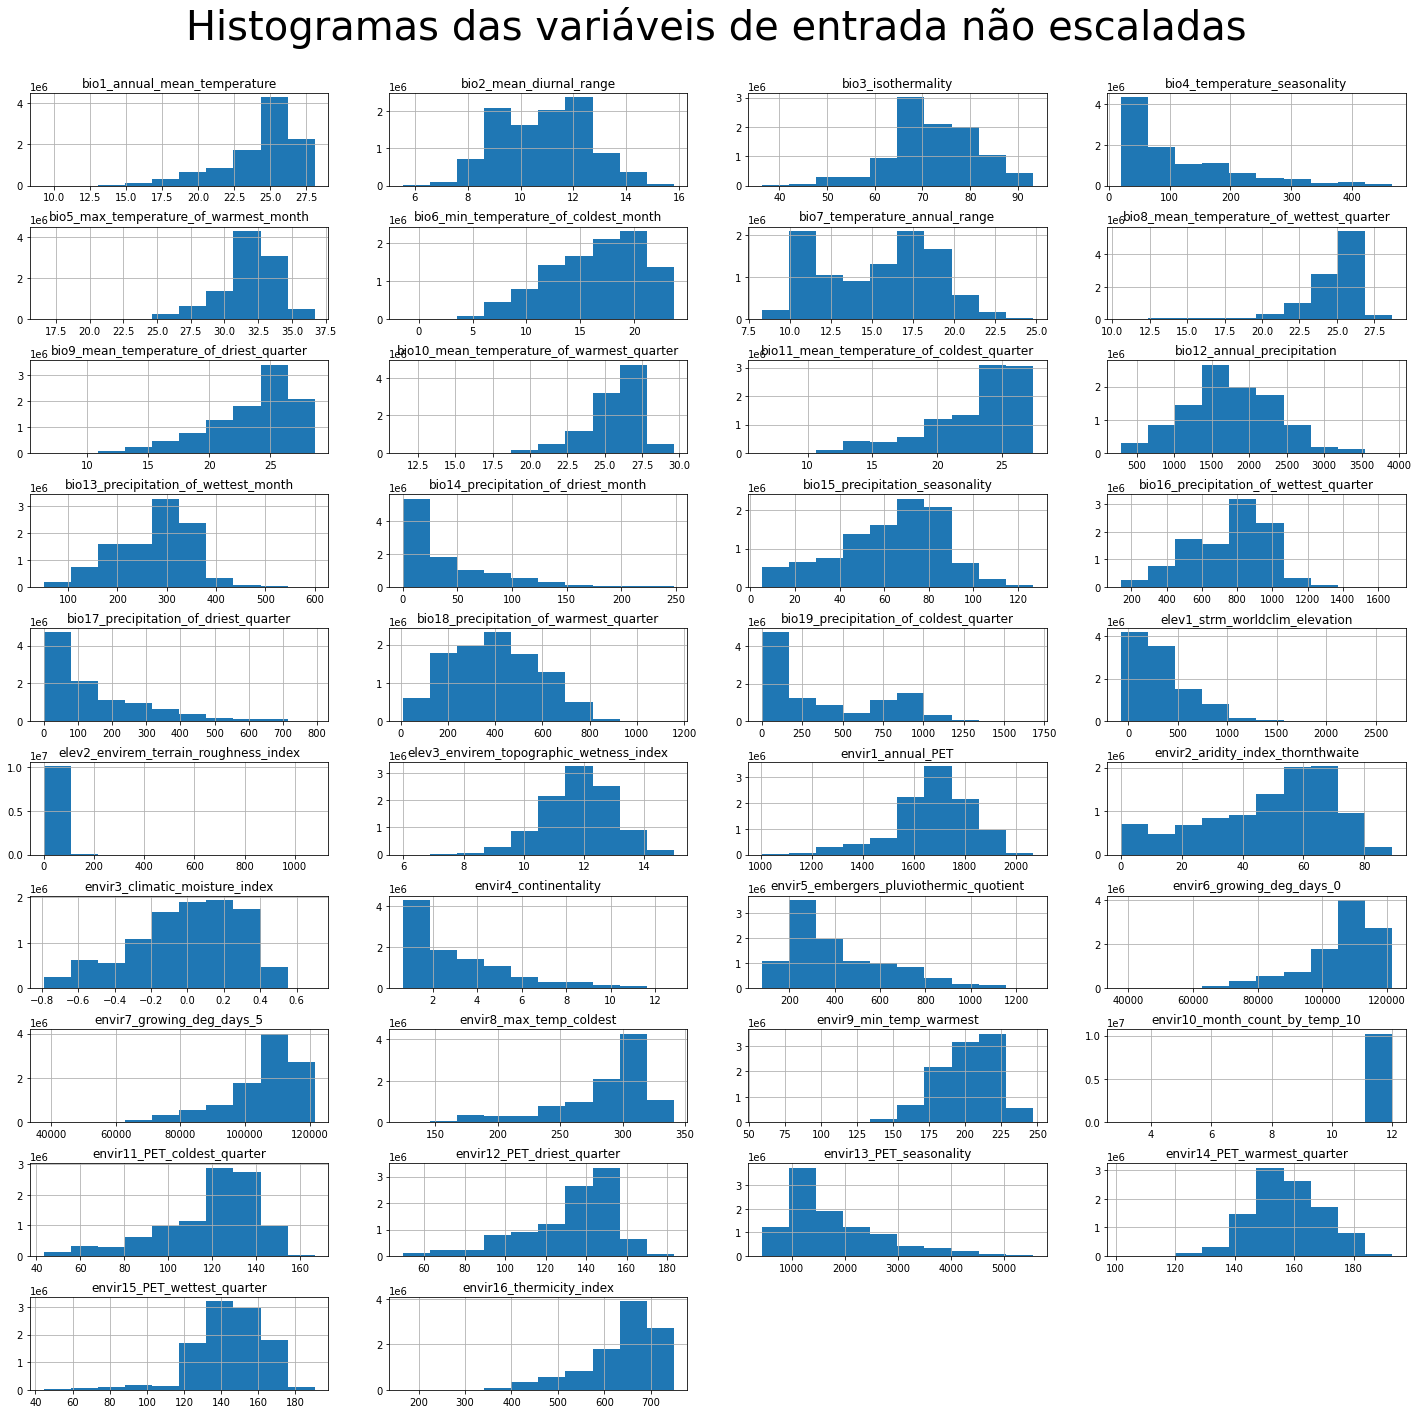

<Figure size 432x288 with 0 Axes>

In [ ]:
saving_input_vars_histograms(selection_filtered_brazil_env_info_coords_df,f"{histograms_output_path}/not_scaled_histograms_variables","Histogramas das variáveis de entrada não escaladas")
del selection_filtered_brazil_env_info_coords_df

Scaled Histograms

In [ ]:
scaled_filtered_brazil_env_info_coords_df =  pd.read_csv(f"{base_csv_files_path}/scaled_filtered_brazil_coords_env_info.csv")
selection_scaled_filtered_brazil_env_info_coords_df = scaled_filtered_brazil_env_info_coords_df[scaled_filtered_brazil_env_info_coords_df.columns.difference(['row','col','latitude','longitude'])]
del scaled_filtered_brazil_env_info_coords_df
selection_scaled_filtered_brazil_env_info_coords_df = selection_scaled_filtered_brazil_env_info_coords_df[natsorted(selection_scaled_filtered_brazil_env_info_coords_df.columns)]
selection_scaled_filtered_brazil_env_info_coords_df.head()

,bio1_annual_mean_temperature,bio2_mean_diurnal_range,bio3_isothermality,bio4_temperature_seasonality,bio5_max_temperature_of_warmest_month,bio6_min_temperature_of_coldest_month,bio7_temperature_annual_range,bio8_mean_temperature_of_wettest_quarter,bio9_mean_temperature_of_driest_quarter,bio10_mean_temperature_of_warmest_quarter,bio11_mean_temperature_of_coldest_quarter,bio12_annual_precipitation,bio13_precipitation_of_wettest_month,bio14_precipitation_of_driest_month,bio15_precipitation_seasonality,bio16_precipitation_of_wettest_quarter,bio17_precipitation_of_driest_quarter,bio18_precipitation_of_warmest_quarter,bio19_precipitation_of_coldest_quarter,elev1_strm_worldclim_elevation,elev2_envirem_terrain_roughness_index,elev3_envirem_topographic_wetness_index,envir1_annual_PET,envir2_aridity_index_thornthwaite,envir3_climatic_moisture_index,envir4_continentality,envir5_embergers_pluviothermic_quotient,envir6_growing_deg_days_0,envir7_growing_deg_days_5,envir8_max_temp_coldest,envir9_min_temp_warmest,envir10_month_count_by_temp_10,envir11_PET_coldest_quarter,envir12_PET_driest_quarter,envir13_PET_seasonality,envir14_PET_warmest_quarter,envir15_PET_wettest_quarter,envir16_thermicity_index
0,0.557601,-0.498083,1.042928,-0.848437,0.180436,0.688699,-0.841709,0.416451,0.585338,0.325590,0.690302,0.700851,0.306753,0.703105,-0.960030,0.219595,0.777324,1.339033,-0.215828,-0.278530,-0.389038,0.566255,0.643951,-0.939639,0.780598,-0.766348,0.589571,0.581052,0.564583,0.768949,0.376457,0.26874,0.634557,0.398772,-0.634609,-0.085361,-0.013055,0.600689
1,0.554426,-0.489888,1.054551,-0.845071,0.180436,0.688699,-0.841709,0.413051,0.580064,0.321891,0.685217,0.695760,0.316006,0.681466,-0.954105,0.219595,0.763913,1.328629,-0.221356,-0.271037,-0.404840,0.658427,0.643754,-0.932323,0.780598,-0.766348,0.585924,0.581052,0.564583,0.768949,0.376457,0.26874,0.633861,0.398450,-0.636109,-0.085361,-0.005971,0.600689
2,0.556807,-0.502180,1.037116,-0.851163,0.180436,0.688699,-0.841709,0.416451,0.585338,0.321891,0.690302,0.694487,0.316006,0.659827,-0.955694,0.216283,0.770619,1.328629,-0.218592,-0.276389,-0.345396,0.358867,0.642421,-0.927589,0.780598,-0.766348,0.581355,0.579482,0.563108,0.768949,0.376457,0.26874,0.633514,0.397807,-0.638305,0.004471,-0.005971,0.600689
3,0.556013,-0.489888,1.054552,-0.842169,0.180436,0.688699,-0.841709,0.416451,0.580064,0.325590,0.685217,0.705943,0.316006,0.681466,-0.948148,0.226218,0.763913,1.354638,-0.221356,-0.275319,-0.492626,0.635384,0.642421,-0.943512,0.780598,-0.741464,0.595944,0.581838,0.565321,0.752768,0.376457,0.26874,0.626562,0.391376,-0.618650,-0.064553,-0.023867,0.600689
4,0.553633,-0.485791,1.060363,-0.845598,0.180436,0.688699,-0.841709,0.409651,0.580064,0.321891,0.685217,0.704670,0.325259,0.659827,-0.950507,0.226218,0.770619,1.349436,-0.218592,-0.269967,-0.426661,0.675709,0.642569,-0.942651,0.780598,-0.766348,0.590454,0.579482,0.563108,0.768949,0.376457,0.26874,0.633861,0.398450,-0.638854,0.004471,-0.005971,0.600689


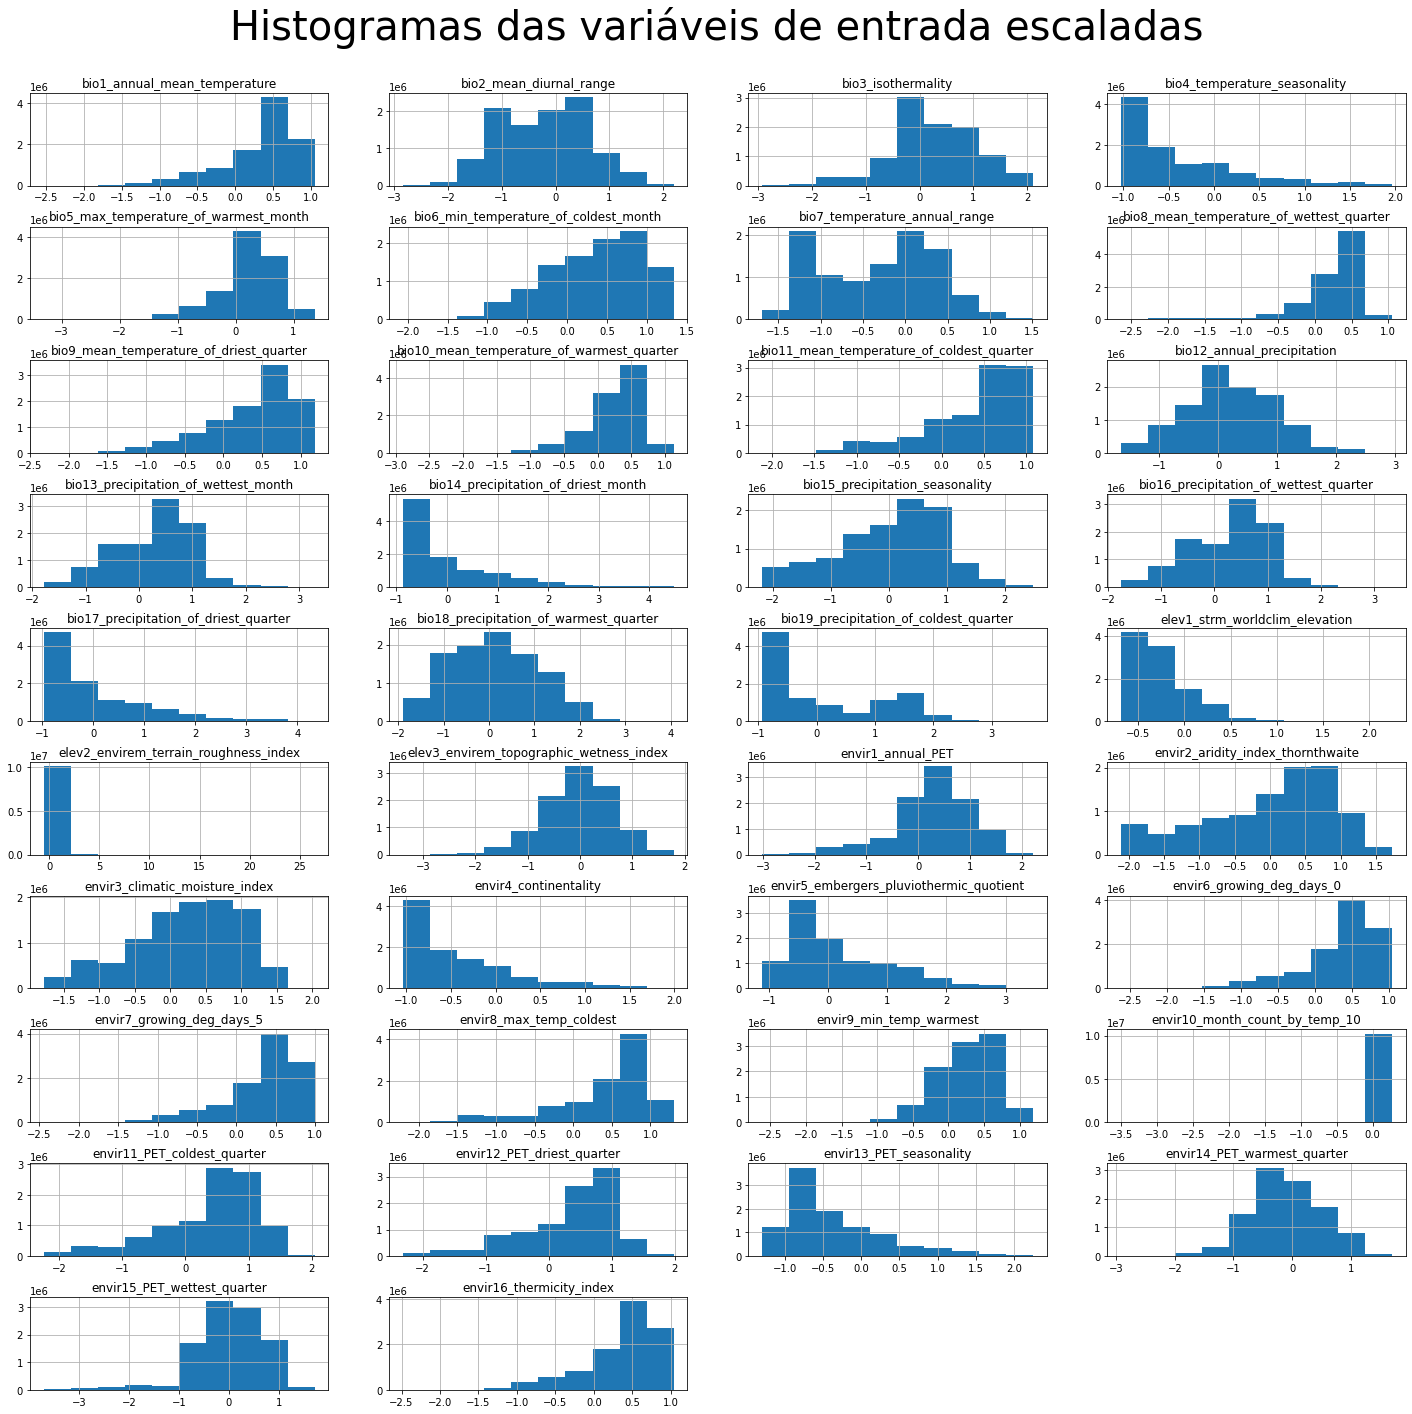

<Figure size 432x288 with 0 Axes>

In [ ]:
saving_input_vars_histograms(selection_scaled_filtered_brazil_env_info_coords_df,f"{histograms_output_path}/scaled_histograms_variables","Histogramas das variáveis de entrada escaladas")
del selection_scaled_filtered_brazil_env_info_coords_df